File paths

In [1]:
train_file = '/work/data/splits/splits_0.050/train.json'
val_file = '/work/data/splits/splits_0.050/val.json'
test_file = '/work/data/splits/splits_0.050/test.json'
import os

path_to_save = '/work/data/models14_6'
os.system(f'mkdir -p {path_to_save}')
path_to_res = '/work/data/results/14_6_2023_tp_graph_5re.txt'

import

In [2]:
%load_ext autoreload
%autoreload 2
import json
import dgl
from sklearn.metrics import f1_score
import torch as th
import dgl.nn.pytorch as dglnn
import torch.nn as nn
from dgl.dataloading import GraphDataLoader
import torch.nn.functional as F
import networkx as nx
import warnings
from feature_extraction.base_featurizer import BaseFeaturizer
import torch
from graph_construction.tps_graph import create_dummy_dgl_graph, tps_graph
import numpy as np

from dgl_classifier.trainer import GraphDataset,snap_pred, tps_to_dgl, get_clasification_vec,\
tps_graph_const, extract_data, runner


import warnings

from preprocessing.utils import load_BGPS_from_json
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

In [3]:
#seed
dgl.seed(1223)

Model

In [4]:
class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.dropout = torch.nn.Dropout(.2)
        self.conv1 = dglnn.RelGraphConv(in_dim, hidden_dim, 8)
        #self.conv1 = dglnn.GraphConv(in_dim, hidden_ˇdim)
        self.conv2 = dglnn.RelGraphConv(hidden_dim, hidden_dim, 8)
        #self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, h, rel_types):
        # Apply graph convolution and activation.
        h = self.dropout(h)
        h = F.relu(self.conv1(g, h, rel_types))
        h = self.dropout(h)
        h = F.relu(self.conv2(g, h, rel_types))
        h = self.dropout(h)
        with g.local_scope():
            g.ndata['node_features'] = h
            # Calculate graph representation by average readout.
            hg = dgl.mean_nodes(g, 'node_features')
            return F.softmax( self.classify(hg), dim=1)
            #return F.sigmoid( self.classify(hg))
#model = Classifier(113, 20, 1)

hyperparameters

In [10]:
early_stop =500
model = Classifier(114, 64, 2)
#lr = 0.01
lr = 0.001
#wd = 5e-4
wd = 0.001
epochs = 300
#epochs = 100
add_thres=False
thres = 0.5
verbosity=10

In [8]:
train_dataloader, val_dataloader, test_dataloader = extract_data(train_file, val_file, test_file, community_no=30, batch_size = 50, verbose=True,  is_run_clust=True, clust_verbose=False)

/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return th.as_tensor(data, dtype=dtype)


# of Removed: 37
Clustering error <http://www.wikidata.org/prop/direct/P669> not in train log
Clustering error <http://www.wikidata.org/prop/direct/P439> not in train log
Clustering error <http://www.wikidata.org/prop/direct/P4659> not in train log
Clustering error <http://www.wikidata.org/prop/direct/P3987> not in train log
Clustering error <http://www.wikidata.org/prop/direct/P2868> not in train log
Clustering error <http://www.wikidata.org/prop/direct/P647> not in train log
Clustering error <http://www.wikidata.org/prop/direct/P1923> not in train log
Clustering error <http://www.wikidata.org/prop/direct/P532> not in train log
Clustering error <http://www.wikidata.org/prop/direct/P781> not in train log
Clustering error <http://www.wikidata.org/prop/direct/P2021> not in train log
Clustering error <http://www.wikidata.org/prop/direct/P2517> not in train log
Clustering error <http://www.wikidata.org/prop/direct/P154> not in train log
Clustering error <http://www.wikidata.org/prop/direct

In [11]:
#best_model_path = runner(train_dataloader,val_dataloader,test_dataloader,model, early_stop, lr, wd, epochs, path_to_res, path_to_save=path_to_save,loss_type='mse')
best_model_path = runner(train_dataloader,val_dataloader,test_dataloader,model, 
                         early_stop, lr, wd, epochs, path_to_res, 
                         path_to_save=path_to_save,add_thres = add_thres, pred_thres=thres,
                        verbosity=verbosity)

Epoch 1
--------------------------------------------------------------
Epoch:    1        1 Batch loss: 0.664082 Batch F1: 0.5909090909090909
Epoch:    1        2 Batch loss: 0.697986 Batch F1: 0.358974358974359
Epoch:    1        3 Batch loss: 0.682035 Batch F1: 0.30303030303030304
Epoch:    1        4 Batch loss: 0.684508 Batch F1: 0.29411764705882354
Epoch:    1        5 Batch loss: 0.701970 Batch F1: 0.28571428571428575
Train Avg Loss    1: 0.686116

Train Avg F1    1: 0.36654913713737247

Val Avg Loss    1: 0.699057

Val Avg F1    1:  0.22843822843822845

Optimal Val loss (Epoch 1): 0.6990565359592438

Epoch 2
--------------------------------------------------------------
Epoch:    2        1 Batch loss: 0.690470 Batch F1: 0.1935483870967742
Epoch:    2        2 Batch loss: 0.647410 Batch F1: 0.3846153846153846
Epoch:    2        3 Batch loss: 0.681473 Batch F1: 0.3225806451612903
Epoch:    2        4 Batch loss: 0.658473 Batch F1: 0.14814814814814814
Epoch:    2        5 Batch lo

In [12]:
import json

In [13]:
results = json.load(open(path_to_res))

In [14]:
#print('best f1', np.max(results['val_f1']), np.argmax(results['val_f1']))
print('best f1 val', results['val_f1'][np.argmax(results['val_f1'])])
print('corr f1 train', results['train_f1'][np.argmax(results['val_f1'])])
print('corr f1 test', results['test_f1'][np.argmax(results['val_f1'])])
#print('best f1 train', np.max(results['train_f1']), np.argmax(results['train_f1']))

best f1 val 0.7170329670329669
corr f1 train 0.730663387306142
corr f1 test 0.6414285714285715


In [15]:
np.argmax(results['val_f1'])

31

In [16]:
import matplotlib.pyplot as plt

(0.0, 1.0)

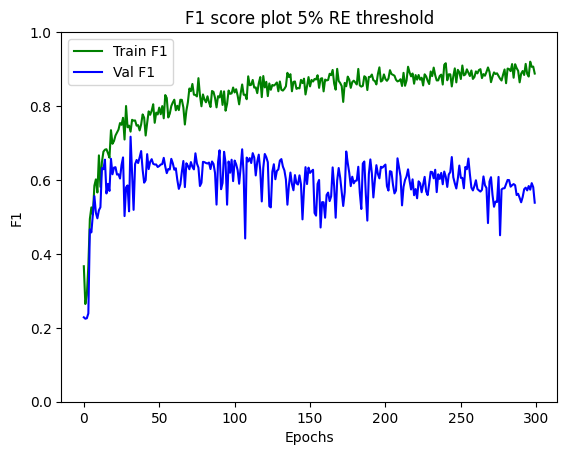

In [17]:
plt.title('F1 score plot 5% RE threshold')
plt.ylabel('F1')
plt.xlabel('Epochs')
plt.plot(results['train_f1'],'-g', label='Train F1')
plt.plot(results['val_f1'],'-b', label='Val F1')
plt.legend(loc='upper left')
plt.ylim([0.0,1.0])

In [18]:
list(results.keys())

['train_loss',
 'val_loss',
 'test_loss',
 'train_f1',
 'val_f1',
 'test_f1',
 'train_prec',
 'val_prec',
 'test_prec',
 'train_recall',
 'val_recall',
 'test_recall']

corr precision train 0.8172619047619047
corr precision val 0.8365384615384616
corr precision test 0.6291208791208791


(0.0, 1.0)

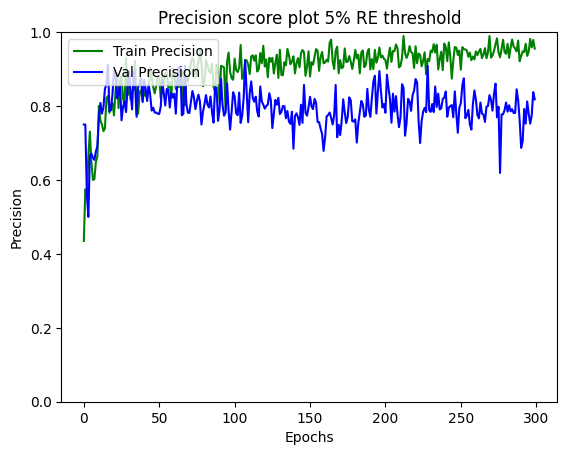

In [19]:
print('corr precision train', results['train_prec'][np.argmax(results['val_f1'])])
print('corr precision val', results['val_prec'][np.argmax(results['val_f1'])])
print('corr precision test', results['test_prec'][np.argmax(results['val_f1'])])
plt.title('Precision score plot 5% RE threshold')
plt.ylabel('Precision')
plt.xlabel('Epochs')
plt.plot(results['train_prec'],'-g', label='Train Precision')
plt.plot(results['val_prec'],'-b', label='Val Precision')
plt.legend(loc='upper left')
plt.ylim([0.0,1.0])

corr recall train 0.6764444444444444
corr recall val 0.634375
corr recall test 0.6547619047619048


(0.0, 1.0)

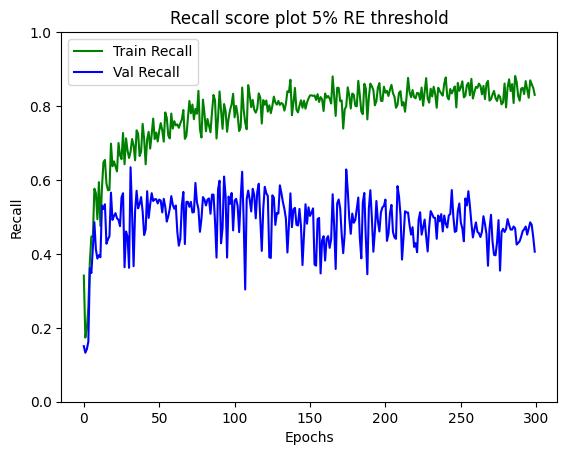

In [20]:
print('corr recall train', results['train_recall'][np.argmax(results['val_f1'])])
print('corr recall val', results['val_recall'][np.argmax(results['val_f1'])])
print('corr recall test', results['test_recall'][np.argmax(results['val_f1'])])
plt.title('Recall score plot 5% RE threshold')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.plot(results['train_recall'],'-g', label='Train Recall')
plt.plot(results['val_recall'],'-b', label='Val Recall')
plt.legend(loc='upper left')
plt.ylim([0.0,1.0])

In [21]:
import torch
model = torch.load(best_model_path)
model.eval()
model

Classifier(
  (dropout): Dropout(p=0.2, inplace=False)
  (conv1): RelGraphConv(
    (linear_r): TypedLinear(in_size=114, out_size=64, num_types=8)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (conv2): RelGraphConv(
    (linear_r): TypedLinear(in_size=64, out_size=64, num_types=8)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (classify): Linear(in_features=64, out_features=2, bias=True)
)

In [22]:
best_model_path
#path_to_res

'/work/data/models14_6/best_f1_model_32.pt'

In [30]:
from dgl_classifier. trainer import predict2samples
print(train_file)
train_data, val_data,test_data = predict2samples(model,train_file, val_file, test_file, community_no=30, verbose=True, clust_verbose=False, clust_load_path='/work/data/confs/14June/pred_clust.json')

/work/data/splits/splits_0.050/train.json


In [31]:
for k in train_data.keys():
    print(train_data[k])
    break

{'bloom_runtime': 0.067109028, 'jena_runtime': 0.048155545, 'leapfrog': 41030009, 'path': '/leapfrog-rdf-benchmark/results/optionals/Op3', 'gt': False, 'bgp_construction_duration': 9.584426879882812e-05, 'tps_const_duration': 0.00031876564025878906, 'prediction': 0, 'inference_time': 0.005647182464599609}


Average runtime on workload

In [32]:
from dgl_classifier.post import *
train_rt,oracle_rt_train, avg_train, oracle_avg_train = avg_runtime(train_data)
#_,_, avg_train_jena, avg_train_blf, lf_train = avg_runtime_type(train_data, leaf=False)
j_rt_train,bf_rt_train, avg_train_jena, avg_train_blf = avg_runtime_type(train_data, leaf=False)

val_rt,oracle_rt_val, avg_val,oracle_avg_val = avg_runtime(val_data)
#_,_, avg_val_jena, avg_val_blf, lf_val = avg_runtime_type(val_data, leaf=False)
j_rt_val,bf_rt_val, avg_val_jena, avg_val_blf = avg_runtime_type(val_data, leaf=False)

test_rt,oracle_rt_test, avg_test,oracle_avg_test = avg_runtime(test_data)
#_,_, avg_test_jena,avg_test_blf, lf_test = avg_runtime_type(test_data, leaf=False)
j_rt_test,bf_rt_test, avg_test_jena,avg_test_blf = avg_runtime_type(test_data, leaf=False)

In [33]:
"""print('Train\n','\tWith Predictions ',round(avg_train,3),', Jena: ', round(avg_train_jena,3), ', Bloom Filter',round(avg_train_blf,3), ', LeapFrog',round(np.sum(lf_train)/len(lf_train),3),', Oracle',round(oracle_avg_train,3))
print('Validation\n','\tWith Predictions ',round(avg_val,3),', Jena: ', round(avg_val_jena,3), ', Bloom Filter',round(avg_val_blf,3), ', LeapFrog',round(np.sum(lf_val)/len(lf_val),3),', Oracle',round(oracle_avg_val,3))
print('Test\n','\tWith Predictions ',round(avg_test,3),', Jena: ', round(avg_test_jena,3), ', Bloom Filter',round(avg_test_blf,3), ', LeapFrog',round(np.sum(lf_test)/len(lf_test),3),', Oracle',round(oracle_avg_test,3))"""
print('Train\n','\tWith Predictions ',round(avg_train,3),', Jena: ', round(avg_train_jena,3), ', Bloom Filter',round(avg_train_blf,3),', Oracle',round(oracle_avg_train,3))
print('Validation\n','\tWith Predictions ',round(avg_val,3),', Jena: ', round(avg_val_jena,3), ', Bloom Filter',round(avg_val_blf,3), ', Oracle',round(oracle_avg_val,3))
print('Test\n','\tWith Predictions ',round(avg_test,3),', Jena: ', round(avg_test_jena,3), ', Bloom Filter',round(avg_test_blf,3),', Oracle',round(oracle_avg_test,3))
#print(avg_val,avg_val_jena,avg_val_blf)
#print(avg_test,avg_test_jena,avg_test_blf)

Train
 	With Predictions  7.425 , Jena:  7.434 , Bloom Filter 8.161 , Oracle 7.407
Validation
 	With Predictions  8.654 , Jena:  8.627 , Bloom Filter 9.019 , Oracle 8.466
Test
 	With Predictions  4.463 , Jena:  4.189 , Bloom Filter 4.637 , Oracle 4.179


Relative difference in average time

In [34]:
print(f'Train: relative Improvement : {round(((avg_train_jena-avg_train)/avg_train_jena)*100,2)}')
print(f'Val: relative Improvement : {round(((avg_val_jena-avg_val)/avg_val_jena)*100,2)}')
print(f'Test: relative Improvement : {round(((avg_test_jena-avg_test)/avg_test_jena)*100,2)}')

Train: relative Improvement : 0.13
Val: relative Improvement : -0.31
Test: relative Improvement : -6.54


Optimal relative difference in average for oracle

In [35]:
print(f'Train: relative Improvement : {round(((avg_train_jena-oracle_avg_train)/avg_train_jena)*100,2)}')
print(f'Val: relative Improvement : {round(((avg_val_jena-oracle_avg_val)/avg_val_jena)*100,2)}')
print(f'Test: relative Improvement : {round(((avg_test_jena-oracle_avg_test)/avg_test_jena)*100,2)}')

Train: relative Improvement : 0.36
Val: relative Improvement : 1.86
Test: relative Improvement : 0.24


In [36]:
def boxplots(jbf_rt, oracle_rt, jena_rt):
    for rt, title in zip([jbf_rt, oracle_rt, jena_rt], ['JenaBloom','Oracle', 'Jena']):
        print(title)
        print("Mean ", np.mean(rt))
        print("STD ", np.std(rt))
        print("Min ", np.min(rt))
        print("25% ", np.quantile(rt,q=0.25))
        print("50% ", np.quantile(rt,q=0.5))
        print("75% ", np.quantile(rt,q=0.75))
        print("Max ", np.max(rt))

        plt.clf()
        plt.figure(figsize=(3,6))
        plt.ylabel('Seconds')
        plt.title(title)
        plt.boxplot(rt)
        plt.show()
#boxplots(val_rt,oracle_rt_val,j_rt_val)

Validation Relative Runtime Improvement for Oracle
Mean  6.293506882109521
STD  7.481646635155949
Min  0.0
25%  0.0
50%  5.7310596340322375
75%  9.594890260122437
Max  42.86617701833492


<Figure size 640x480 with 0 Axes>

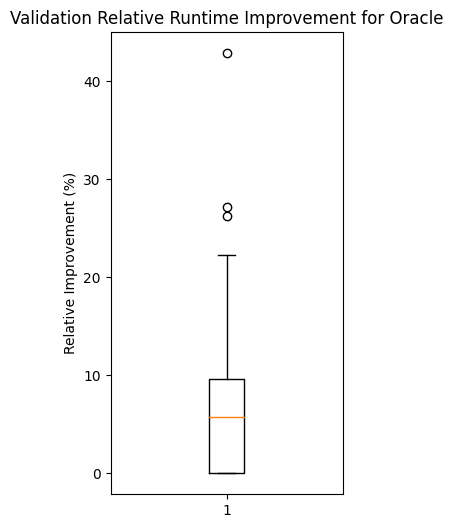

Test Relative Runtime Improvement for Oracle
Mean  4.719166737101756
STD  5.759712989191208
Min  0.0
25%  0.0
50%  2.5850219991638577
75%  7.7024995180602325
Max  23.67658765737796


<Figure size 640x480 with 0 Axes>

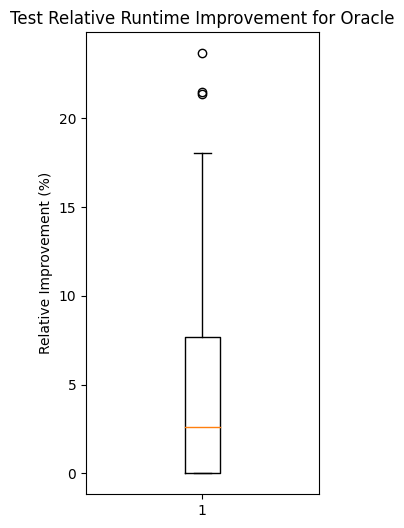

Validation Relative Runtime Improvement for Prediction
Mean  3.6480812504662095
STD  7.785500274910848
Min  -14.76927675960424
25%  0.0
50%  0.0
75%  6.377315636003499
Max  42.86617701833492


<Figure size 640x480 with 0 Axes>

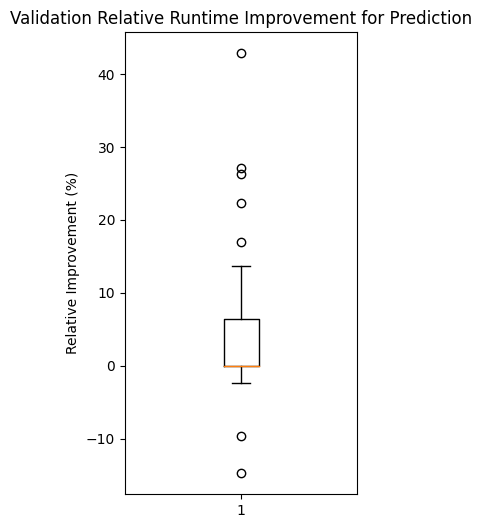

Relative Error  -9.654  JenaBloom RT  0.062  Jena RT  0.056 Absolute difference in MS 5.452
Relative Error  -0.337  JenaBloom RT  0.018  Jena RT  0.018 Absolute difference in MS 0.061
Relative Error  -14.769  JenaBloom RT  20.564  Jena RT  17.917 Absolute difference in MS 2646.276
Relative Error  -2.327  JenaBloom RT  0.034  Jena RT  0.033 Absolute difference in MS 0.775
Relative Improvement  17.005  JenaBloom RT  0.026  Jena RT  0.031 Absolute difference in MS 5.242
Relative Improvement  10.751  JenaBloom RT  0.192  Jena RT  0.215 Absolute difference in MS 23.152
Relative Improvement  42.866  JenaBloom RT  0.028  Jena RT  0.048 Absolute difference in MS 20.636
Relative Improvement  22.282  JenaBloom RT  0.007  Jena RT  0.01 Absolute difference in MS 2.127
Relative Improvement  26.28  JenaBloom RT  0.024  Jena RT  0.033 Absolute difference in MS 8.58
Relative Improvement  10.721  JenaBloom RT  0.005  Jena RT  0.006 Absolute difference in MS 0.641
Relative Improvement  11.749  JenaBloom

<Figure size 640x480 with 0 Axes>

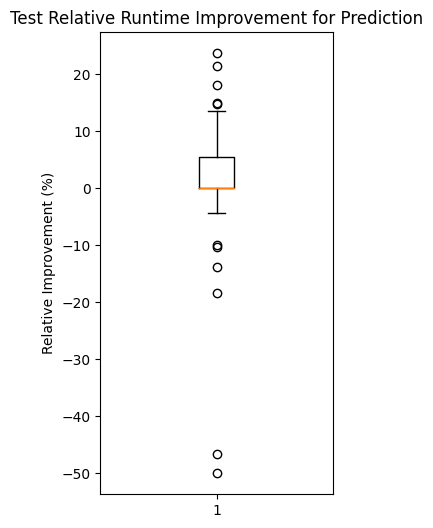

Relative Error  -10.372  JenaBloom RT  0.013  Jena RT  0.012 Absolute difference in MS 1.245
Relative Error  -1.438  JenaBloom RT  0.255  Jena RT  0.251 Absolute difference in MS 3.617
Relative Error  -9.94  JenaBloom RT  0.002  Jena RT  0.002 Absolute difference in MS 0.204
Relative Error  -49.981  JenaBloom RT  0.055  Jena RT  0.037 Absolute difference in MS 18.48
Relative Error  -3.107  JenaBloom RT  0.035  Jena RT  0.034 Absolute difference in MS 1.062
Relative Error  -18.426  JenaBloom RT  0.003  Jena RT  0.003 Absolute difference in MS 0.514
Relative Error  -46.525  JenaBloom RT  0.067  Jena RT  0.046 Absolute difference in MS 21.386
Relative Error  -4.277  JenaBloom RT  0.228  Jena RT  0.219 Absolute difference in MS 9.36
Relative Error  -13.744  JenaBloom RT  199.385  Jena RT  175.293 Absolute difference in MS 24092.965
Relative Improvement  11.458  JenaBloom RT  0.005  Jena RT  0.005 Absolute difference in MS 0.617
Relative Improvement  21.363  JenaBloom RT  0.003  Jena RT  0.

In [37]:
def relative_importance_plot(j_bl_rt, j_rt, title, print_not_improve=False, improve_perc=None):
    re_s = [((jr-jb)/jr)*100 for jb, jr in zip(j_bl_rt, j_rt)]
    
    print(title)
    print("Mean ", np.mean(re_s))
    print("STD ", np.std(re_s))
    print("Min ", np.min(re_s))
    print("25% ", np.quantile(re_s,q=0.25))
    print("50% ", np.quantile(re_s,q=0.5))
    print("75% ", np.quantile(re_s,q=0.75))
    print("Max ", np.max(re_s))

    plt.clf()
    plt.figure(figsize=(3,6))
    plt.ylabel('Relative Improvement (%)')
    plt.title(title)
    plt.boxplot(re_s)
    plt.show()
    if print_not_improve:
        for idx,x in enumerate(re_s):
            if x < 0:
                print('Relative Error ',round(x,3),' JenaBloom RT ', round(j_bl_rt[idx],3),' Jena RT ', round(j_rt[idx],3), 'Absolute difference in MS',round((j_bl_rt[idx]- j_rt[idx])*1e3,3))
    if improve_perc != None:
        for idx,x in enumerate(re_s):
            if x > improve_perc:
                print('Relative Improvement ',round(x,3),' JenaBloom RT ', round(j_bl_rt[idx],3),' Jena RT ', round(j_rt[idx],3), 'Absolute difference in MS',round((j_rt[idx] -j_bl_rt[idx] )*1e3,3))
        
relative_importance_plot(oracle_rt_val, j_rt_val, 'Validation Relative Runtime Improvement for Oracle')
relative_importance_plot(oracle_rt_test, j_rt_test, 'Test Relative Runtime Improvement for Oracle')
relative_importance_plot(val_rt, j_rt_val, 'Validation Relative Runtime Improvement for Prediction', print_not_improve=True,improve_perc=9.5)
relative_importance_plot(test_rt, j_rt_test, 'Test Relative Runtime Improvement for Prediction', print_not_improve=True,improve_perc=9.5)

Validation Runtime Improvement for Oracle
Mean  160.652
STD  1397.923
Min  0.0
25%  0.0
50%  0.749
75%  4.992
Max  12895.253


<Figure size 640x480 with 0 Axes>

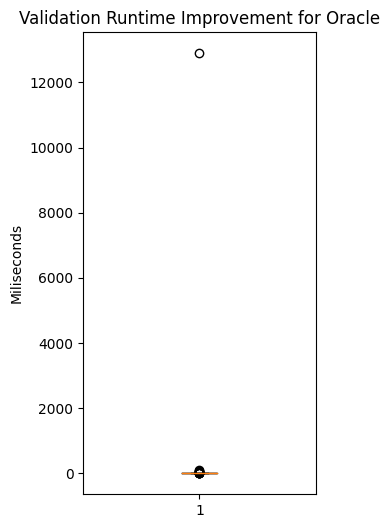

Test Runtime Improvement for Oracle
Mean  10.086
STD  40.904
Min  0.0
25%  0.0
50%  0.394
75%  4.155
Max  366.089


<Figure size 640x480 with 0 Axes>

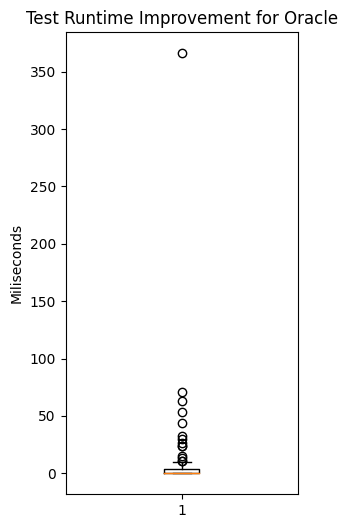

In [38]:
def absolute_gain(j_bl_rt, j_rt, title):
    re_s = [((jr-jb)*1e3) for jb, jr in zip(j_bl_rt, j_rt)]
    print(title)
    print("Mean ", round(np.mean(re_s),3))
    print("STD ", round(np.std(re_s),3))
    print("Min ", round(np.min(re_s),3))
    print("25% ", round(np.quantile(re_s,q=0.25),3))
    print("50% ", round(np.quantile(re_s,q=0.5),3))
    print("75% ", round(np.quantile(re_s,q=0.75),3))
    print("Max ", round(np.max(re_s),3))

    plt.clf()
    plt.figure(figsize=(3,6))
    plt.ylabel('Miliseconds')
    plt.title(title)
    plt.boxplot(re_s)
    plt.show()
absolute_gain(oracle_rt_val, j_rt_val, 'Validation Runtime Improvement for Oracle')
absolute_gain(oracle_rt_test, j_rt_test, 'Test Runtime Improvement for Oracle')

Cumulative runtime on workload

In [39]:
cum_pred_train = cum_runtime(train_data)
#jena_cum_train , blf_cum_train, lf_cum_train, oracle_cum_train = cum_runtime_type(train_data)
jena_cum_train , blf_cum_train, oracle_cum_train = cum_runtime_type(train_data, leaf=False)

cum_pred_val = cum_runtime(val_data)
jena_cum_val , blf_cum_val, oracle_cum_val = cum_runtime_type(val_data,leaf=False)
#jena_cum_val , blf_cum_val, lf_cum_val, oracle_cum_val = cum_runtime_type(val_data)

cum_pred_test = cum_runtime(test_data)
jena_cum_test , blf_cum_test, oracle_cum_test = cum_runtime_type(test_data, leaf=False)
#jena_cum_test , blf_cum_test, lf_cum_test, oracle_cum_test = cum_runtime_type(test_data)

In [40]:
print(f'Train:\n')
print(f'\tCumulative Runtime (with Predictions): {round(cum_pred_train,3)}')
print(f'\tCumulative Runtime (with Jena): {round(jena_cum_train,3)}')
print(f'\tCumulative Runtime (with BF): {round(blf_cum_train,3)}')
#print(f'\tCumulative Runtime (with LeapFrog): {round(lf_cum_train,3)}')
print(f'\tCumulative Runtime (with Oracle): {round(oracle_cum_train,3)}')

print(f'Val:\n')
print(f'\tCumulative Runtime (with Predictions): {round(cum_pred_val,3)}')
print(f'\tCumulative Runtime (with Jena): {round(jena_cum_val,3)}')
print(f'\tCumulative Runtime (with BF): {round(blf_cum_val,3)}')
#print(f'\tCumulative Runtime (with LeapFrog): {round(lf_cum_val,3)}')
print(f'\tCumulative Runtime (with Oracle): {round(oracle_cum_val,3)}')

print(f'Test:\n')
print(f'\tCumulative Runtime (with Predictions): {round(cum_pred_test,3)}')
print(f'\tCumulative Runtime (with Jena): {round(jena_cum_test,3)}')
print(f'\tCumulative Runtime (with BF): {round(blf_cum_test,3)}')
#print(f'\tCumulative Runtime (with LeapFrog): {round(lf_cum_test,3)}')
print(f'\tCumulative Runtime (with Oracle): {round(oracle_cum_test,3)}')

Train:

	Cumulative Runtime (with Predictions): 1848.742
	Cumulative Runtime (with Jena): 1851.141
	Cumulative Runtime (with BF): 2032.165
	Cumulative Runtime (with Oracle): 1844.416
Val:

	Cumulative Runtime (with Predictions): 726.931
	Cumulative Runtime (with Jena): 724.656
	Cumulative Runtime (with BF): 757.571
	Cumulative Runtime (with Oracle): 711.162
Test:

	Cumulative Runtime (with Predictions): 383.808
	Cumulative Runtime (with Jena): 360.234
	Cumulative Runtime (with BF): 398.759
	Cumulative Runtime (with Oracle): 359.366


In [41]:
print('best model epoch', np.argmax(results['val_f1']))

best model epoch 31


j_rt_train,bf_rt_train, j_rt_val,bf_rt_val, j_rt_test,bf_rt_test

In [42]:
def bxp_plot(rt, ylim=None, title=None):
    print("Mean ", np.mean(rt))
    print("STD ", np.std(rt))
    print("Min ", np.min(rt))
    print("25% ", np.quantile(rt,q=0.25))
    print("50% ", np.quantile(rt,q=0.5))
    print("75% ", np.quantile(rt,q=0.75))
    print("Max ", np.max(rt))

    plt.clf()
    plt.figure(figsize=(3,6))
    if ylim != None:
        plt.ylim(*ylim)
    plt.ylabel('Seconds')
    plt.title(title)
    plt.boxplot(rt)
    plt.show()

Mean  7.434301843405623
STD  40.535017448252006
Min  0.0022104570000000003
25%  0.013859112000000002
50%  0.039378483000000006
75%  0.19598642900000002
Max  348.978890497


<Figure size 640x480 with 0 Axes>

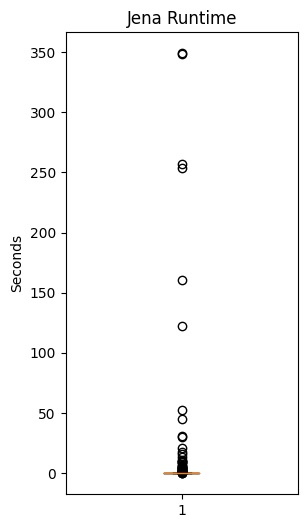

In [43]:
bxp_plot(j_rt_train, title='Jena Runtime')

In [44]:
for i, t in zip([j_rt_train,bf_rt_train, j_rt_val,bf_rt_val, j_rt_test,bf_rt_test],
                ['Jena Runtime Traininig','Bloom Filter Runtimes Trainining','Jena Runtime Validation','Bloom Filter Runtime Validation',
                'Jena Runtime Test','Bloom Filter Runtimes Test']):
    #bxp_plot(i, title=t)
    pass

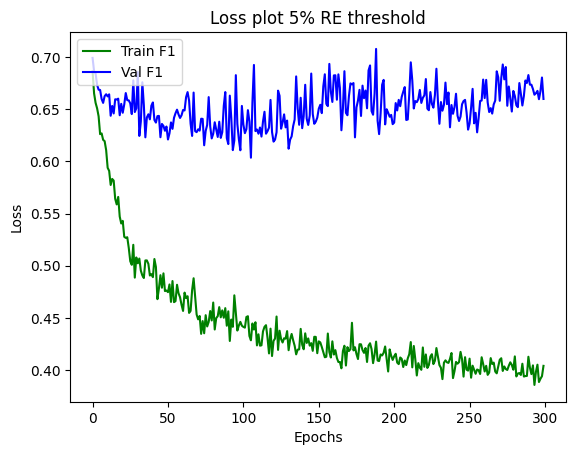

In [45]:
plt.title('Loss plot 5% RE threshold')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(results['train_loss'],'-g', label='Train F1')
plt.plot(results['val_loss'],'-b', label='Val F1')
plt.legend(loc='upper left')
#plt.ylim([0.0,1.0])

In [ ]:
print('best val loss epoch: ', np.argmin(results['val_loss'])+1)
best_val_epoch = np.argmin(results['val_loss'])+1

In [ ]:
import torch
model = torch.load(f'/work/data/models8_6/model_{best_val_epoch}.pt')
model.eval()
model

In [ ]:
plt.title(f'Runtime Improvement on Model with Lowest Loss (Epoch {best_val_epoch})')
plt.ylabel('Va Relative Improvement')
plt.xlabel('Classification Threshold')
plt.plot(metrics_data['model threshold'],metrics_data['Train Relative Improvement'],'-g', label='Train Relative Improvement')
plt.plot(metrics_data['model threshold'],metrics_data['Val Relative Improvement'],'-b', label='Val Relative Improvement')
plt.plot(metrics_data['model threshold'],metrics_data['Test Relative Improvement'],'-r', label='Test Relative Improvement')
plt.legend(loc='upper left')

In [ ]:
print(metrics_data['Train Relative Improvement'][np.argmax(metrics_data['Val Relative Improvement'])])
print(metrics_data['Val Relative Improvement'][np.argmax(metrics_data['Val Relative Improvement'])])
print(metrics_data['Test Relative Improvement'][np.argmax(metrics_data['Val Relative Improvement'])])
print(metrics_data['model threshold'][np.argmax(metrics_data['Val Relative Improvement'])])